Testing the original GraphCast implementation by Google Deepmind (https://github.com/google-deepmind/graphcast/tree/main/graphcast)

In [ ]:
from src import JPLDGIMDataset
import matplotlib.pyplot as plt
import sys
import numpy as np
import torch
import datetime
import xarray

from graphcast.xarray_jax import Dataset
from graphcast import icosahedral_mesh, model_utils, grid_mesh_connectivity
from graphcast.typed_graph import NodeSet, EdgeSet, TypedGraph, Context, EdgeSetKey, EdgesIndices

Load data

In [3]:
gim_dir = "/mnt/ionosphere-data/jpld/webdataset"

gim_dataset = JPLDGIMDataset(
    data_dir=gim_dir,
    date_start=None,
    date_end=None,
)

date = datetime.datetime(2023, 10, 1, 0, 0)
tec_map = gim_dataset[date]


JPLD
Directory  : /mnt/ionosphere-data/jpld/webdataset
Loading tar files index from cache: /mnt/ionosphere-data/jpld/webdataset/tar_files_index
Start date : 2010-05-13 00:00:00
End date   : 2024-07-31 23:45:00
Delta      : 15 minutes
Loading dates from cache: /mnt/ionosphere-data/jpld/webdataset/dates_index_2010-05-13T00:00:00_2024-07-31T23:45:00
TEC maps total    : 498,623
TEC maps available: 498,481
TEC maps dropped  : 142
Start date : 2010-05-13 00:00:00
End date   : 2024-07-31 23:45:00
Delta      : 15 minutes
Loading dates from cache: /mnt/ionosphere-data/jpld/webdataset/dates_index_2010-05-13T00:00:00_2024-07-31T23:45:00
TEC maps total    : 498,623
TEC maps available: 498,481
TEC maps dropped  : 142


(tensor([[[0.2373, 0.2373, 0.2373,  ..., 0.2373, 0.2373, 0.2373],
         [0.2784, 0.2784, 0.2784,  ..., 0.2703, 0.2703, 0.2784],
         [0.3102, 0.3180, 0.3180,  ..., 0.3023, 0.3023, 0.3102],
         ...,
         [0.4913, 0.4913, 0.4846,  ..., 0.4980, 0.4980, 0.4980],
         [0.4846, 0.4846, 0.4846,  ..., 0.4913, 0.4913, 0.4913],
         [0.4779, 0.4779, 0.4779,  ..., 0.4846, 0.4779, 0.4779]]]), '2023-10-01T00:00:00')
torch.Size([1, 180, 360]) torch.Size([180, 360]) 2023-10-01T00:00:00


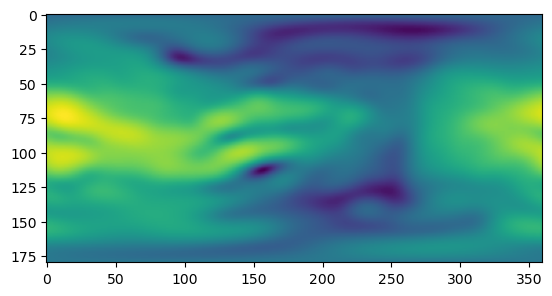

In [4]:
print(tec_map)
print(tec_map[0].shape, tec_map[0][0].shape, tec_map[1])

plt.imshow(tec_map[0][0]), tec_map[0][0].shape
plt.show()

This is Linnea's version of GraphCast, adjusted to work with TEC data. This model will predict the vTEC over the Earth's surface, on a grid of latitude and longitude.

In [5]:
# Create standard GIM grid coordinates (1-degree resolution)
# Latitudes: 90 to -89 (180 points)
latitudes = np.arange(90, -90, -1, dtype=np.float32)  # Top to bottom: 90, 89, 88, ..., -89
# Longitudes: -180 to 179 (360 points) 
longitudes = np.arange(-180, 180, 1, dtype=np.float32)  # Left to right: -180, -179, ..., 179

print(f"Latitudes shape: {latitudes.shape}, range: [{latitudes.min()}, {latitudes.max()}]")
print(f"Longitudes shape: {longitudes.shape}, range: [{longitudes.min()}, {longitudes.max()}]")

# Remove the channel dimension and convert to numpy for xarray
if len(tec_map[0].shape) == 3 and tec_map[0].shape[0] == 1:
    tec_array = tec_map[0][0].numpy()  # Remove channel dimension: [180, 360]
elif len(tec_map[0].shape) == 2:
    tec_array = tec_map[0].numpy()  # Already [180, 360]
else:
    tec_array = tec_map[0].numpy()

print(f"TEC array shape after processing: {tec_array.shape}")

# Create xarray Dataset with time dimension
time_coord = [np.datetime64(datetime.datetime(2023, 10, 1, 0, 0))]

tec_map_ds = xarray.Dataset(
    {
        "vTEC": (["time", "lat", "lon"], tec_array[np.newaxis, :, :]),  # Add time dimension
    },
    coords={
        "time": time_coord,
        "lat": latitudes,
        "lon": longitudes,
    },
    attrs={
        "description": "Total Electron Content (TEC) data from JPL Global Ionosphere Maps",
        "units": "TECU (normalized)",
        "source": "JPL GIM"
    }
)

print(f"xarray Dataset: {tec_map_ds}")
print(f"vTEC variable shape: {tec_map_ds.vTEC.shape}")

Latitudes shape: (180,), range: [-89.0, 90.0]
Longitudes shape: (360,), range: [-180.0, 179.0]
TEC array shape after processing: (180, 360)
xarray Dataset: <xarray.Dataset> Size: 261kB
Dimensions:  (time: 1, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[us] 8B 2023-10-01
  * lat      (lat) float32 720B 90.0 89.0 88.0 87.0 ... -86.0 -87.0 -88.0 -89.0
  * lon      (lon) float32 1kB -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
Data variables:
    vTEC     (time, lat, lon) float32 259kB 0.2373 0.2373 ... 0.4779 0.4779
Attributes:
    description:  Total Electron Content (TEC) data from JPL Global Ionospher...
    units:        TECU (normalized)
    source:       JPL GIM
vTEC variable shape: (1, 180, 360)
xarray Dataset: <xarray.Dataset> Size: 261kB
Dimensions:  (time: 1, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[us] 8B 2023-10-01
  * lat      (lat) float32 720B 90.0 89.0 88.0 87.0 ... -86.0 -87.0 -88.0 -89.0
  * lon      (lon) float32 1kB -180.0